In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q transformers

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

**Load Data**

In [4]:
data = pd.read_csv("/content/drive/MyDrive/winemag-data_first150k.csv")
data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...,...
150925,150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


**Data Cleaning and  Imputing of null values**

In [5]:
#drop the index column
data=data.drop(columns=['Unnamed: 0'])
data["price"].describe()

count    137235.000000
mean         33.131482
std          36.322536
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

In [6]:
#Convert text features into sentences
data['country'] = 'The country of this wine is ' + data['country'] + '. '
data['designation'] = 'The designation of this wine is ' + data['designation'] + '. '
data['province'] = 'The province of this wine is ' + data['province'] + '. '
data['region_1'] = 'The region of this wine is ' + data['region_1'] + '. '
data['region_2'] = 'The secondary region of this wine is ' + data['region_2'] + '. '
data['variety'] = 'The variety of this wine is ' + data['variety'] + '. '
data['winery'] = 'The winery from this wine is ' + data['winery'] + '. '
data['points'] = 'The rating given to this wine is ' + data["points"].astype("string") + ". "

In [7]:
data['description'].isna().sum()

0

In [8]:
# drop null and duplicate values
data.dropna(subset=['price'], inplace=True)
data.drop_duplicates(subset=['description'], inplace=True)
data.nunique()

country           46
description    89108
designation    28345
points            21
price            357
province         446
region_1        1197
region_2          18
variety          619
winery         13852
dtype: int64

In [9]:
#replace nan values for text features with empty string
data[['country', 'designation', 'region_1', 'region_2', 'province', 'variety', 'winery']] = data[['country','designation', 'region_1', 'region_2', 'province', 'variety', 'winery']].fillna("")
data.isnull().sum()

country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
variety        0
winery         0
dtype: int64

In [10]:

#replace nan values for text features with empty string
data[['country', 'designation', 'region_1', 'region_2', 'province']] = data[['country','designation', 'region_1', 'region_2', 'province']].fillna("")
data.isnull().sum()

country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
variety        0
winery         0
dtype: int64

In [11]:
bins = pd.qcut(data["price"], q=4)
bins

0         (40.0, 2300.0]
1         (40.0, 2300.0]
2         (40.0, 2300.0]
3         (40.0, 2300.0]
4         (40.0, 2300.0]
               ...      
149634     (3.999, 16.0]
149635     (3.999, 16.0]
149637     (3.999, 16.0]
149638     (3.999, 16.0]
149639     (3.999, 16.0]
Name: price, Length: 89108, dtype: category
Categories (4, interval[float64, right]): [(3.999, 16.0] < (16.0, 25.0] < (25.0, 40.0] <
                                           (40.0, 2300.0]]

In [12]:
categories = bins.cat.categories.tolist()
target_names = [str(i) for i in categories]

In [13]:
bins.cat.codes

0         3
1         3
2         3
3         3
4         3
         ..
149634    0
149635    0
149637    0
149638    0
149639    0
Length: 89108, dtype: int8

In [14]:
# ordinal_prices = tf.keras.utils.to_categorical(bins.cat.codes, num_classes=5)
# data["price_categorical"] = ordinal_prices.tolist()
data["price_categorical"] = bins.cat.codes
data
# ordinal_prices

,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_categorical
0,The country of this wine is US.,This tremendous 100% varietal wine hails from ...,The designation of this wine is Martha's Viney...,The rating given to this wine is 96.,235.0,The province of this wine is California.,The region of this wine is Napa Valley.,The secondary region of this wine is Napa.,The variety of this wine is Cabernet Sauvignon.,The winery from this wine is Heitz.,3
1,The country of this wine is Spain.,"Ripe aromas of fig, blackberry and cassis are ...",The designation of this wine is Carodorum Sele...,The rating given to this wine is 96.,110.0,The province of this wine is Northern Spain.,The region of this wine is Toro.,,The variety of this wine is Tinta de Toro.,The winery from this wine is Bodega Carmen Rod...,3
2,The country of this wine is US.,Mac Watson honors the memory of a wine once ma...,The designation of this wine is Special Select...,The rating given to this wine is 96.,90.0,The province of this wine is California.,The region of this wine is Knights Valley.,The secondary region of this wine is Sonoma.,The variety of this wine is Sauvignon Blanc.,The winery from this wine is Macauley.,3
3,The country of this wine is US.,"This spent 20 months in 30% new French oak, an...",The designation of this wine is Reserve.,The rating given to this wine is 96.,65.0,The province of this wine is Oregon.,The region of this wine is Willamette Valley.,The secondary region of this wine is Willamett...,The variety of this wine is Pinot Noir.,The winery from this wine is Ponzi.,3
4,The country of this wine is France.,"This is the top wine from La Bégude, named aft...",The designation of this wine is La Brûlade.,The rating given to this wine is 95.,66.0,The province of this wine is Provence.,The region of this wine is Bandol.,,The variety of this wine is Provence red blend.,The winery from this wine is Domaine de la Bég...,3
...,...,...,...,...,...,...,...,...,...,...,...
149634,The country of this wine is France.,Atypically light in body and reticent on the n...,,The rating given to this wine is 84.,15.0,The province of this wine is Alsace.,The region of this wine is Alsace.,,The variety of this wine is Gewürztraminer.,The winery from this wine is W. Gisselbrecht.,0
149635,The country of this wine is US.,A Syrah-Grenache blend that's dry and rustical...,The designation of this wine is Bungalow Red.,The rating given to this wine is 84.,15.0,The province of this wine is California.,The region of this wine is Santa Barbara County.,The secondary region of this wine is Central C...,The variety of this wine is Syrah-Grenache.,The winery from this wine is Casa Barranca.,0
149637,The country of this wine is US.,"Outside of the vineyard, wines like this are w...",,The rating given to this wine is 84.,6.0,The province of this wine is California.,The region of this wine is California.,The secondary region of this wine is Californi...,The variety of this wine is Merlot.,The winery from this wine is Delicato.,0
149638,The country of this wine is Argentina.,"Heavy and basic, with melon and pineapple arom...",,The rating given to this wine is 84.,9.0,The province of this wine is Mendoza Province.,The region of this wine is Uco Valley.,,The variety of this wine is Sauvignon Blanc.,The winery from this wine is Finca El Portillo.,0


In [15]:
data['description'] = data['description'].astype(str)
data['description_noDigits'] = data['description'].str.replace(r'\d', '', regex=True)

In [16]:
data["description_features"] = data["description_noDigits"] + " " + data["points"] + data['variety'] + data['country'] + data['province'] + data["region_1"]
# + data['winery'] + data["region_2"] + data["designation"]
data["description_features"].iloc[0]

'This tremendous % varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy –. The rating given to this wine is 96. The variety of this wine is Cabernet Sauvignon. The country of this wine is US. The province of this wine is California. The region of this wine is Napa Valley. '

In [17]:
data_selection = 10000
sample_data = data.sample(data_selection)
# (train_texts, test_texts, train_labels, test_labels) = train_test_split(list(data["description_features"][:data_selection]), list(df["price_categorical"][:data_selection]), test_size=0.2, stratify=list(df["price_categorical"][:data_selection]), random_state=1)

(train_data, test_data) = train_test_split(sample_data, test_size=0.2, random_state=1)
train_data

,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_categorical,description_noDigits,description_features
143398,The country of this wine is US.,A nice Zin that's provides some real richness ...,The designation of this wine is Select Vineyar...,The rating given to this wine is 85.,11.0,The province of this wine is California.,The region of this wine is Lodi.,The secondary region of this wine is Central V...,The variety of this wine is Zinfandel.,The winery from this wine is Woodbridge.,0,A nice Zin that's provides some real richness ...,A nice Zin that's provides some real richness ...
29095,The country of this wine is France.,"This is a ripe and fruity wine, with soft tann...",,The rating given to this wine is 88.,45.0,The province of this wine is Burgundy.,The region of this wine is Monthélie.,,The variety of this wine is Pinot Noir.,The winery from this wine is Bouchard Père & F...,3,"This is a ripe and fruity wine, with soft tann...","This is a ripe and fruity wine, with soft tann..."
8489,The country of this wine is US.,"A stony, wet cement-like aromas meets Anjou li...",,The rating given to this wine is 89.,16.0,The province of this wine is California.,The region of this wine is Paso Robles.,The secondary region of this wine is Central C...,The variety of this wine is Sauvignon Blanc.,The winery from this wine is Robert Hall.,0,"A stony, wet cement-like aromas meets Anjou li...","A stony, wet cement-like aromas meets Anjou li..."
53329,The country of this wine is US.,"A good, rich, savory Merlot, although it's a l...",The designation of this wine is Limited Select...,The rating given to this wine is 87.,38.0,The province of this wine is California.,The region of this wine is Santa Ynez Valley.,The secondary region of this wine is Central C...,The variety of this wine is Merlot.,The winery from this wine is Gainey.,2,"A good, rich, savory Merlot, although it's a l...","A good, rich, savory Merlot, although it's a l..."
79110,The country of this wine is Argentina.,Attractive berry and dried fig aromas are rich...,The designation of this wine is Tonada.,The rating given to this wine is 89.,20.0,The province of this wine is Mendoza Province.,The region of this wine is Mendoza.,,The variety of this wine is Malbec.,The winery from this wine is Finca La Anita.,1,Attractive berry and dried fig aromas are rich...,Attractive berry and dried fig aromas are rich...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46367,The country of this wine is Italy.,A bold Sauvignon with aromas of crushed tomato...,,The rating given to this wine is 87.,22.0,The province of this wine is Northeastern Italy.,The region of this wine is Colli Orientali del...,,The variety of this wine is Sauvignon.,The winery from this wine is La Tunella.,1,A bold Sauvignon with aromas of crushed tomato...,A bold Sauvignon with aromas of crushed tomato...
54054,The country of this wine is Italy.,This Barbera d'Alba from the warm 2005 vintage...,,The rating given to this wine is 82.,20.0,The province of this wine is Piedmont.,The region of this wine is Barbera d'Alba.,,The variety of this wine is Barbera.,The winery from this wine is Cascina del Monas...,1,This Barbera d'Alba from the warm vintage def...,This Barbera d'Alba from the warm vintage def...
49963,The country of this wine is US.,"With Cabernet Franc and Merlot blended in, thi...",,The rating given to this wine is 84.,34.0,The province of this wine is California.,The region of this wine is Sierra Foothills.,The secondary region of this wine is Sierra Fo...,The variety of this wine is Cabernet Sauvignon.,The winery from this wine is Wise Villa.,2,"With Cabernet Franc and Merlot blended in, thi...","With Cabernet Franc and Merlot blended in, thi..."
143755,The country of this wine is Argentina.,"Clean, simple and unadulterated, with a pleasa...",,The rating given to this wine is 85.,8.0,The province of this wine is Mendoza Province.,The region of this wine is Me

**Feature Selection**

In [18]:
percs = pd.qcut(data["description_features"].str.len(), [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.])
percs

0         (524.0, 1018.0]
1          (488.0, 524.0]
2          (464.0, 488.0]
3         (524.0, 1018.0]
4         (524.0, 1018.0]
               ...       
149634     (393.0, 411.0]
149635     (411.0, 428.0]
149637     (464.0, 488.0]
149638     (393.0, 411.0]
149639     (464.0, 488.0]
Name: description_features, Length: 89108, dtype: category
Categories (10, interval[float64, right]): [(191.999, 346.0] < (346.0, 373.0] < (373.0, 393.0] <
                                            (393.0, 411.0] ... (445.0, 464.0] < (464.0, 488.0] <
                                            (488.0, 524.0] < (524.0, 1018.0]]

<Axes: >

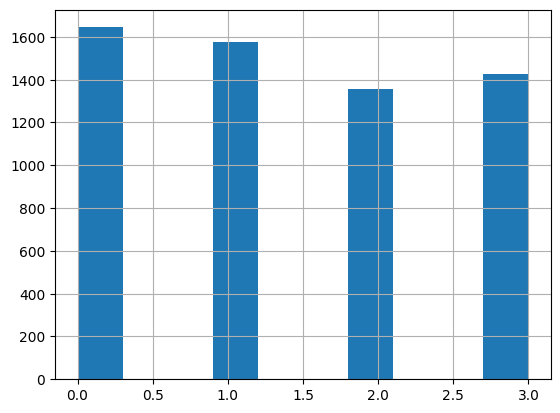

In [19]:
(train_data, valid_data) = train_test_split(train_data, test_size=0.25, random_state=1)
train_data['price_categorical'].hist()

In [20]:
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel, Trainer, TFRobertaForMaskedLM, AutoConfig, TFRobertaPreTrainedModel, RobertaModel
import tensorflow as tf
from sklearn.metrics import classification_report

In [21]:
train_labels = np.asarray(train_data['price_categorical'].astype('int64'))
valid_labels = np.asarray(valid_data['price_categorical'].astype('int64'))
test_labels = np.asarray(test_data['price_categorical'].astype('int64'))

In [22]:
max_length = 335

In [23]:
#config = AutoConfig.from_pretrained("roberta-base")
roberta = TFRobertaModel.from_pretrained("roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [24]:
#roberta_model = TFRobertaForMaskedLM(config=config, output_hidden_states=True, return_dict=True)
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [25]:
roberta_train_encodings = roberta_tokenizer(list(train_data['description_noDigits']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
roberta_valid_encodings = roberta_tokenizer(list(valid_data['description_noDigits']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
roberta_test_encodings = roberta_tokenizer(list(test_data['description_noDigits']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')

In [26]:
#input_ids_train = np.array(select_field(roberta_train_encodings, 'input_ids'))
#token_type_ids = tf.zeros(shape =[roberta_train_encodings.input_ids, max_length])
#attention_masks_train = np.array(select_field(roberta_train_encodings, 'attention_mask'))

In [27]:
#input_ids_train = roberta_train_encodings['input_ids']
#attention_masks_train = roberta_train_encodings['attention_mask']
#token_type_ids = tf.zeros(shape =[len(roberta_train_encodings.input_ids), max_length])
#valid_token_type_ids = tf.zeros(shape =[len(roberta_valid_encodings.input_ids), max_length])
#print(token_type_ids)

#input_ids_test = roberta_test_encodings['input_ids']
#attention_masks_test = roberta_test_encodings['attention_mask']


In [28]:
hidden_sizes = [16384, 2048, 512]

In [29]:
def create_roberta_model(backend,
                         num_classes=4,
                         dropout_rate=0.3,
                         learning_rate = 1e-5):

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  input = backend(input_ids, attention_mask=attention_mask)[0][:, 0, :]
  #print(backend(input_ids, attention_mask=attention_mask))
  hidden_with_dropout = tf.keras.layers.Dropout(dropout_rate)(input)
  hidden = tf.keras.layers.Dense(2048, activation='swish', name='hidden_layer')(hidden_with_dropout)
  hidden = tf.keras.layers.Dense(512, activation='swish', name='hidden_layer_2')(hidden)
  #

  #input = tf.reshape(input, (-1, 768))
  #hidden = tf.keras.layers.Dense(128)(input)
  #hidden = tf.reshape(hidden, (-1, 420, 128))
  #hidden = tf.transpose(hidden, perm =[0, 1, 2])
  #hidden = tf.keras.layers.Dense(128)(hidden)
  #hidden = tf.keras.layers.Flatten()(hidden)

  #for i, hidden_layer_size in enumerate(hidden_sizes):
    #hidden = tf.keras.layers.Dense(hidden_layer_size, activation='relu',name=f'hidden_layer_{i}')(hidden)

  classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss = 'sparse_categorical_crossentropy',
            metrics = 'accuracy')

  return classification_model

In [30]:
roberta_model = create_roberta_model(roberta, num_classes=4)
roberta_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 335)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 335)]       0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [31]:
print('Training...')
history = roberta_model.fit(x = [roberta_train_encodings.input_ids, roberta_train_encodings.attention_mask],
                    y=np.asarray(train_labels),
                    validation_data=([roberta_valid_encodings.input_ids, roberta_valid_encodings.attention_mask], valid_labels),
                    shuffle=True,
                    batch_size=8,
                    validation_batch_size=8,
                    epochs=4 )

Training...
Epoch 1/4


750/750 [==============================] - 569s 698ms/step - loss: 1.2979 - accuracy: 0.3667 - val_loss: 1.1793 - val_accuracy: 0.4460
Epoch 2/4
750/750 [==============================] - 471s 629ms/step - loss: 1.1295 - accuracy: 0.4790 - val_loss: 1.1265 - val_accuracy: 0.4535
Epoch 3/4
750/750 [==============================] - 508s 678ms/step - loss: 1.0342 - accuracy: 0.5302 - val_loss: 1.1268 - val_accuracy: 0.4870
Epoch 4/4
750/750 [==============================] - 505s 674ms/step - loss: 0.9255 - accuracy: 0.5852 - val_loss: 1.2225 - val_accuracy: 0.4750


In [35]:
predictions = roberta_model.predict([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(test_labels, predictions.numpy(), target_names=target_names))

63/63 [==============================] - 44s 698ms/step
                precision    recall  f1-score   support

 (3.999, 16.0]       0.61      0.57      0.59       572
  (16.0, 25.0]       0.33      0.50      0.39       501
  (25.0, 40.0]       0.44      0.17      0.25       480
(40.0, 2300.0]       0.56      0.63      0.59       447

      accuracy                           0.47      2000
     macro avg       0.48      0.47      0.45      2000
  weighted avg       0.48      0.47      0.46      2000



In [37]:
score = roberta_model.evaluate([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask],
                                                  test_labels)

63/63 [==============================] - 46s 727ms/step - loss: 1.2119 - accuracy: 0.4700


Roberta W/ only 2 classes and no additional features

In [25]:
two_bins = pd.qcut(data["price"], q=2)
print(two_bins)
two_categories = two_bins.cat.categories.tolist()
two_target_names = [str(i) for i in two_categories]
data["two_price_categorical"] = two_bins.cat.codes
data

0         (25.0, 2300.0]
1         (25.0, 2300.0]
2         (25.0, 2300.0]
3         (25.0, 2300.0]
4         (25.0, 2300.0]
               ...      
149634     (3.999, 25.0]
149635     (3.999, 25.0]
149637     (3.999, 25.0]
149638     (3.999, 25.0]
149639     (3.999, 25.0]
Name: price, Length: 89108, dtype: category
Categories (2, interval[float64, right]): [(3.999, 25.0] < (25.0, 2300.0]]


,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_categorical,description_noDigits,description_features,two_price_categorical
0,The country of this wine is US.,This tremendous 100% varietal wine hails from ...,The designation of this wine is Martha's Viney...,The rating given to this wine is 96.,235.0,The province of this wine is California.,The region of this wine is Napa Valley.,The secondary region of this wine is Napa.,The variety of this wine is Cabernet Sauvignon.,The winery from this wine is Heitz.,3,This tremendous % varietal wine hails from Oak...,This tremendous % varietal wine hails from Oak...,1
1,The country of this wine is Spain.,"Ripe aromas of fig, blackberry and cassis are ...",The designation of this wine is Carodorum Sele...,The rating given to this wine is 96.,110.0,The province of this wine is Northern Spain.,The region of this wine is Toro.,,The variety of this wine is Tinta de Toro.,The winery from this wine is Bodega Carmen Rod...,3,"Ripe aromas of fig, blackberry and cassis are ...","Ripe aromas of fig, blackberry and cassis are ...",1
2,The country of this wine is US.,Mac Watson honors the memory of a wine once ma...,The designation of this wine is Special Select...,The rating given to this wine is 96.,90.0,The province of this wine is California.,The region of this wine is Knights Valley.,The secondary region of this wine is Sonoma.,The variety of this wine is Sauvignon Blanc.,The winery from this wine is Macauley.,3,Mac Watson honors the memory of a wine once ma...,Mac Watson honors the memory of a wine once ma...,1
3,The country of this wine is US.,"This spent 20 months in 30% new French oak, an...",The designation of this wine is Reserve.,The rating given to this wine is 96.,65.0,The province of this wine is Oregon.,The region of this wine is Willamette Valley.,The secondary region of this wine is Willamett...,The variety of this wine is Pinot Noir.,The winery from this wine is Ponzi.,3,"This spent months in % new French oak, and in...","This spent months in % new French oak, and in...",1
4,The country of this wine is France.,"This is the top wine from La Bégude, named aft...",The designation of this wine is La Brûlade.,The rating given to this wine is 95.,66.0,The province of this wine is Provence.,The region of this wine is Bandol.,,The variety of this wine is Provence red blend.,The winery from this wine is Domaine de la Bég...,3,"This is the top wine from La Bégude, named aft...","This is the top wine from La Bégude, named aft...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149634,The country of this wine is France.,Atypically light in body and reticent on the n...,,The rating given to this wine is 84.,15.0,The province of this wine is Alsace.,The region of this wine is Alsace.,,The variety of this wine is Gewürztraminer.,The winery from this wine is W. Gisselbrecht.,0,Atypically light in body and reticent on the n...,Atypically light in body and reticent on the n...,0
149635,The country of this wine is US.,A Syrah-Grenache blend that's dry and rustical...,The designation of this wine is Bungalow Red.,The rating given to this wine is 84.,15.0,The province of this wine is California.,The region of this wine is Santa Barbara County.,The secondary region of this wine is Central C...,The variety of this wine is Syrah-Grenache.,The winery from this wine is Casa Barranca.,0,A Syrah-Grenache blend that's dry and rustical...,A Syrah-Grenache blend that's dry and rustical...,0
149637,The country of this wine is US.,"Outside of the vineyard, wines like this are w...",,The rating given to this wine is 84.,6.0,The province of this wine is California.,The region of this wine is California.,The secondary region of this wine is Californi...,The variety of this wine is Merlot.,The winery from this wine is Delicato.,0,"Outside of the vineyard, wines like this are w...","Outside of the vineyard, wines like this are w...",0
149638,The country of this 

In [26]:
two_sample_data = data.sample(data_selection, random_state=1)
(two_train_data, two_test_data) = train_test_split(two_sample_data, test_size=0.2, random_state=1)
(two_train_data, two_valid_data) = train_test_split(two_train_data, test_size=0.25, random_state=1)

In [27]:
train_labels = np.asarray(two_train_data['two_price_categorical'].astype('int64'))
valid_labels = np.asarray(two_valid_data['two_price_categorical'].astype('int64'))
test_labels = np.asarray(two_test_data['two_price_categorical'].astype('int64'))

In [28]:
max_length = 335

In [29]:
two_percs = pd.qcut(two_train_data["description_noDigits"].str.len(), q=10)
print(two_percs)

49592      (221.0, 236.0]
50783      (204.0, 221.0]
149343     (269.0, 294.0]
59602      (330.0, 681.0]
111711     (157.0, 184.0]
               ...       
81854      (157.0, 184.0]
56561      (252.0, 269.0]
56273      (157.0, 184.0]
37331     (32.999, 157.0]
105197     (184.0, 204.0]
Name: description_noDigits, Length: 6000, dtype: category
Categories (10, interval[float64, right]): [(32.999, 157.0] < (157.0, 184.0] < (184.0, 204.0] <
                                            (204.0, 221.0] ... (252.0, 269.0] < (269.0, 294.0] <
                                            (294.0, 330.0] < (330.0, 681.0]]


In [30]:
two_train_encodings = roberta_tokenizer(list(two_train_data['description_noDigits']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
two_valid_encodings = roberta_tokenizer(list(two_valid_data['description_noDigits']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
two_test_encodings = roberta_tokenizer(list(two_test_data['description_noDigits']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')

In [31]:
def create_two_class_roberta_model(backend,
                         num_classes=2,
                         dropout_rate=0.3,
                         learning_rate = 1e-5):

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  input = backend(input_ids, attention_mask=attention_mask)[0][:, 0, :]
  #print(backend(input_ids, attention_mask=attention_mask))
  hidden_with_dropout = tf.keras.layers.Dropout(dropout_rate)(input)
  hidden = tf.keras.layers.Dense(2048, activation='swish', name='hidden_layer')(hidden_with_dropout)
  hidden = tf.keras.layers.Dense(512, activation='swish', name='hidden_layer_2')(hidden)
  #

  #input = tf.reshape(input, (-1, 768))
  #hidden = tf.keras.layers.Dense(128)(input)
  #hidden = tf.reshape(hidden, (-1, 420, 128))
  #hidden = tf.transpose(hidden, perm =[0, 1, 2])
  #hidden = tf.keras.layers.Dense(128)(hidden)
  #hidden = tf.keras.layers.Flatten()(hidden)

  #for i, hidden_layer_size in enumerate(hidden_sizes):
    #hidden = tf.keras.layers.Dense(hidden_layer_size, activation='relu',name=f'hidden_layer_{i}')(hidden)

  classification = tf.keras.layers.Dense(2, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss = 'sparse_categorical_crossentropy',
            metrics = 'accuracy')

  return classification_model

In [32]:
roberta_two_class_model = create_two_class_roberta_model(roberta, num_classes=2)
roberta_two_class_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 335)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 335)]       0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [33]:
print('Training...')
history = roberta_two_class_model.fit(x = [two_train_encodings.input_ids, two_train_encodings.attention_mask],
                    y=np.asarray(train_labels),
                    validation_data=([two_valid_encodings.input_ids, two_valid_encodings.attention_mask], valid_labels),
                    shuffle=True,
                    batch_size=8,
                    validation_batch_size=8,
                    epochs=4 )

Training...
Epoch 1/4


750/750 [==============================] - 679s 776ms/step - loss: 0.6013 - accuracy: 0.6753 - val_loss: 0.5558 - val_accuracy: 0.7095
Epoch 2/4
750/750 [==============================] - 479s 639ms/step - loss: 0.5147 - accuracy: 0.7497 - val_loss: 0.6847 - val_accuracy: 0.6730
Epoch 3/4
750/750 [==============================] - 476s 635ms/step - loss: 0.4408 - accuracy: 0.7975 - val_loss: 0.6245 - val_accuracy: 0.7165
Epoch 4/4
750/750 [==============================] - 477s 636ms/step - loss: 0.3447 - accuracy: 0.8492 - val_loss: 0.6029 - val_accuracy: 0.7115


In [34]:
predictions = roberta_two_class_model.predict([two_test_encodings.input_ids, two_test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(test_labels, predictions.numpy(), target_names=two_target_names))

63/63 [==============================] - 51s 750ms/step
                precision    recall  f1-score   support

 (3.999, 25.0]       0.71      0.85      0.78      1080
(25.0, 2300.0]       0.77      0.60      0.68       920

      accuracy                           0.73      2000
     macro avg       0.74      0.72      0.73      2000
  weighted avg       0.74      0.73      0.73      2000



In [35]:
score = roberta_two_class_model.evaluate([two_test_encodings.input_ids, two_test_encodings.attention_mask],
                                                  test_labels)

63/63 [==============================] - 53s 764ms/step - loss: 0.5688 - accuracy: 0.7345


KeyboardInterrupt: ignored

4 class classifier W/ Features

In [22]:
train_labels = np.asarray(train_data['price_categorical'].astype('int64'))
valid_labels = np.asarray(valid_data['price_categorical'].astype('int64'))
test_labels = np.asarray(test_data['price_categorical'].astype('int64'))

In [23]:
max_length = 335

In [24]:
#config = AutoConfig.from_pretrained("roberta-base")
roberta = TFRobertaModel.from_pretrained("roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [25]:
#roberta_model = TFRobertaForMaskedLM(config=config, output_hidden_states=True, return_dict=True)
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [26]:
roberta_train_encodings = roberta_tokenizer(list(train_data['description_features']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
roberta_valid_encodings = roberta_tokenizer(list(valid_data['description_features']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
roberta_test_encodings = roberta_tokenizer(list(test_data['description_features']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')

In [27]:
def create_roberta_model(backend,
                         num_classes=4,
                         dropout_rate=0.3,
                         learning_rate = 1e-5):

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  input = backend(input_ids, attention_mask=attention_mask)[0][:, 0, :]
  #print(backend(input_ids, attention_mask=attention_mask))
  hidden_with_dropout = tf.keras.layers.Dropout(dropout_rate)(input)
  hidden = tf.keras.layers.Dense(2048, activation='swish', name='hidden_layer')(hidden_with_dropout)
  hidden = tf.keras.layers.Dense(512, activation='swish', name='hidden_layer_2')(hidden)
  #

  #input = tf.reshape(input, (-1, 768))
  #hidden = tf.keras.layers.Dense(128)(input)
  #hidden = tf.reshape(hidden, (-1, 420, 128))
  #hidden = tf.transpose(hidden, perm =[0, 1, 2])
  #hidden = tf.keras.layers.Dense(128)(hidden)
  #hidden = tf.keras.layers.Flatten()(hidden)

  #for i, hidden_layer_size in enumerate(hidden_sizes):
    #hidden = tf.keras.layers.Dense(hidden_layer_size, activation='relu',name=f'hidden_layer_{i}')(hidden)

  classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss = 'sparse_categorical_crossentropy',
            metrics = 'accuracy')

  return classification_model

In [28]:
roberta_model = create_roberta_model(roberta, num_classes=4)
roberta_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 335)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 335)]       0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [29]:
print('Training...')
history = roberta_model.fit(x = [roberta_train_encodings.input_ids, roberta_train_encodings.attention_mask],
                    y=np.asarray(train_labels),
                    validation_data=([roberta_valid_encodings.input_ids, roberta_valid_encodings.attention_mask], valid_labels),
                    shuffle=True,
                    batch_size=8,
                    validation_batch_size=8,
                    epochs=4 )

Training...
Epoch 1/4


750/750 [==============================] - 598s 724ms/step - loss: 1.2901 - accuracy: 0.3643 - val_loss: 1.1621 - val_accuracy: 0.4935
Epoch 2/4
750/750 [==============================] - 517s 690ms/step - loss: 1.0548 - accuracy: 0.5142 - val_loss: 0.9940 - val_accuracy: 0.5565
Epoch 3/4
750/750 [==============================] - 518s 690ms/step - loss: 0.9675 - accuracy: 0.5653 - val_loss: 0.9682 - val_accuracy: 0.5645
Epoch 4/4
750/750 [==============================] - 516s 689ms/step - loss: 0.8933 - accuracy: 0.6000 - val_loss: 0.9467 - val_accuracy: 0.5890


In [30]:
predictions = roberta_model.predict([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(test_labels, predictions.numpy(), target_names=target_names))

63/63 [==============================] - 52s 767ms/step
                precision    recall  f1-score   support

 (3.999, 16.0]       0.68      0.75      0.71       529
  (16.0, 25.0]       0.48      0.41      0.44       544
  (25.0, 40.0]       0.42      0.45      0.44       445
(40.0, 2300.0]       0.70      0.69      0.69       482

      accuracy                           0.58      2000
     macro avg       0.57      0.57      0.57      2000
  weighted avg       0.57      0.58      0.57      2000



In [31]:
score = roberta_model.evaluate([roberta_test_encodings.input_ids, roberta_test_encodings.attention_mask],
                                                  test_labels)

63/63 [==============================] - 52s 772ms/step - loss: 0.9636 - accuracy: 0.5755


binary classifier with features

In [25]:
two_bins = pd.qcut(data["price"], q=2)
print(two_bins)
two_categories = two_bins.cat.categories.tolist()
two_target_names = [str(i) for i in two_categories]
data["two_price_categorical"] = two_bins.cat.codes
data

0         (25.0, 2300.0]
1         (25.0, 2300.0]
2         (25.0, 2300.0]
3         (25.0, 2300.0]
4         (25.0, 2300.0]
               ...      
149634     (3.999, 25.0]
149635     (3.999, 25.0]
149637     (3.999, 25.0]
149638     (3.999, 25.0]
149639     (3.999, 25.0]
Name: price, Length: 89108, dtype: category
Categories (2, interval[float64, right]): [(3.999, 25.0] < (25.0, 2300.0]]


,country,description,designation,points,price,province,region_1,region_2,variety,winery,price_categorical,description_noDigits,description_features,two_price_categorical
0,The country of this wine is US.,This tremendous 100% varietal wine hails from ...,The designation of this wine is Martha's Viney...,The rating given to this wine is 96.,235.0,The province of this wine is California.,The region of this wine is Napa Valley.,The secondary region of this wine is Napa.,The variety of this wine is Cabernet Sauvignon.,The winery from this wine is Heitz.,3,This tremendous % varietal wine hails from Oak...,This tremendous % varietal wine hails from Oak...,1
1,The country of this wine is Spain.,"Ripe aromas of fig, blackberry and cassis are ...",The designation of this wine is Carodorum Sele...,The rating given to this wine is 96.,110.0,The province of this wine is Northern Spain.,The region of this wine is Toro.,,The variety of this wine is Tinta de Toro.,The winery from this wine is Bodega Carmen Rod...,3,"Ripe aromas of fig, blackberry and cassis are ...","Ripe aromas of fig, blackberry and cassis are ...",1
2,The country of this wine is US.,Mac Watson honors the memory of a wine once ma...,The designation of this wine is Special Select...,The rating given to this wine is 96.,90.0,The province of this wine is California.,The region of this wine is Knights Valley.,The secondary region of this wine is Sonoma.,The variety of this wine is Sauvignon Blanc.,The winery from this wine is Macauley.,3,Mac Watson honors the memory of a wine once ma...,Mac Watson honors the memory of a wine once ma...,1
3,The country of this wine is US.,"This spent 20 months in 30% new French oak, an...",The designation of this wine is Reserve.,The rating given to this wine is 96.,65.0,The province of this wine is Oregon.,The region of this wine is Willamette Valley.,The secondary region of this wine is Willamett...,The variety of this wine is Pinot Noir.,The winery from this wine is Ponzi.,3,"This spent months in % new French oak, and in...","This spent months in % new French oak, and in...",1
4,The country of this wine is France.,"This is the top wine from La Bégude, named aft...",The designation of this wine is La Brûlade.,The rating given to this wine is 95.,66.0,The province of this wine is Provence.,The region of this wine is Bandol.,,The variety of this wine is Provence red blend.,The winery from this wine is Domaine de la Bég...,3,"This is the top wine from La Bégude, named aft...","This is the top wine from La Bégude, named aft...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149634,The country of this wine is France.,Atypically light in body and reticent on the n...,,The rating given to this wine is 84.,15.0,The province of this wine is Alsace.,The region of this wine is Alsace.,,The variety of this wine is Gewürztraminer.,The winery from this wine is W. Gisselbrecht.,0,Atypically light in body and reticent on the n...,Atypically light in body and reticent on the n...,0
149635,The country of this wine is US.,A Syrah-Grenache blend that's dry and rustical...,The designation of this wine is Bungalow Red.,The rating given to this wine is 84.,15.0,The province of this wine is California.,The region of this wine is Santa Barbara County.,The secondary region of this wine is Central C...,The variety of this wine is Syrah-Grenache.,The winery from this wine is Casa Barranca.,0,A Syrah-Grenache blend that's dry and rustical...,A Syrah-Grenache blend that's dry and rustical...,0
149637,The country of this wine is US.,"Outside of the vineyard, wines like this are w...",,The rating given to this wine is 84.,6.0,The province of this wine is California.,The region of this wine is California.,The secondary region of this wine is Californi...,The variety of this wine is Merlot.,The winery from this wine is Delicato.,0,"Outside of the vineyard, wines like this are w...","Outside of the vineyard, wines like this are w...",0
149638,The country of this 

In [26]:
two_sample_data = data.sample(data_selection, random_state=1)
(two_train_data, two_test_data) = train_test_split(two_sample_data, test_size=0.2, random_state=1)
(two_train_data, two_valid_data) = train_test_split(two_train_data, test_size=0.25, random_state=1)

In [27]:
train_labels = np.asarray(two_train_data['two_price_categorical'].astype('int64'))
valid_labels = np.asarray(two_valid_data['two_price_categorical'].astype('int64'))
test_labels = np.asarray(two_test_data['two_price_categorical'].astype('int64'))

In [28]:
max_length = 335

In [29]:
two_percs = pd.qcut(two_train_data["description_features"].str.len(), q=10)
print(two_percs)

49592       (392.0, 411.0]
50783       (346.0, 373.0]
149343      (463.0, 487.0]
59602       (526.0, 875.0]
111711      (346.0, 373.0]
                ...       
81854       (373.0, 392.0]
56561       (463.0, 487.0]
56273       (346.0, 373.0]
37331     (191.999, 346.0]
105197      (411.0, 426.0]
Name: description_features, Length: 6000, dtype: category
Categories (10, interval[float64, right]): [(191.999, 346.0] < (346.0, 373.0] < (373.0, 392.0] <
                                            (392.0, 411.0] ... (443.0, 463.0] < (463.0, 487.0] <
                                            (487.0, 526.0] < (526.0, 875.0]]


In [30]:
two_train_encodings = roberta_tokenizer(list(two_train_data['description_features']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
two_valid_encodings = roberta_tokenizer(list(two_valid_data['description_features']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
two_test_encodings = roberta_tokenizer(list(two_test_data['description_features']), truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')

In [31]:
def create_two_class_roberta_model(backend,
                         num_classes=2,
                         dropout_rate=0.3,
                         learning_rate = 1e-5):

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  input = backend(input_ids, attention_mask=attention_mask)[0][:, 0, :]
  #print(backend(input_ids, attention_mask=attention_mask))
  hidden_with_dropout = tf.keras.layers.Dropout(dropout_rate)(input)
  hidden = tf.keras.layers.Dense(2048, activation='swish', name='hidden_layer')(hidden_with_dropout)
  hidden = tf.keras.layers.Dense(512, activation='swish', name='hidden_layer_2')(hidden)
  #

  #input = tf.reshape(input, (-1, 768))
  #hidden = tf.keras.layers.Dense(128)(input)
  #hidden = tf.reshape(hidden, (-1, 420, 128))
  #hidden = tf.transpose(hidden, perm =[0, 1, 2])
  #hidden = tf.keras.layers.Dense(128)(hidden)
  #hidden = tf.keras.layers.Flatten()(hidden)

  #for i, hidden_layer_size in enumerate(hidden_sizes):
    #hidden = tf.keras.layers.Dense(hidden_layer_size, activation='relu',name=f'hidden_layer_{i}')(hidden)

  classification = tf.keras.layers.Dense(2, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss = 'sparse_categorical_crossentropy',
            metrics = 'accuracy')

  return classification_model

In [32]:
roberta_two_class_model = create_two_class_roberta_model(roberta, num_classes=2)
roberta_two_class_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 335)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 335)]       0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [33]:
print('Training...')
history = roberta_two_class_model.fit(x = [two_train_encodings.input_ids, two_train_encodings.attention_mask],
                    y=np.asarray(train_labels),
                    validation_data=([two_valid_encodings.input_ids, two_valid_encodings.attention_mask], valid_labels),
                    shuffle=True,
                    batch_size=8,
                    validation_batch_size=8,
                    epochs=4 )

Training...
Epoch 1/4


750/750 [==============================] - 563s 680ms/step - loss: 0.6264 - accuracy: 0.6280 - val_loss: 0.5506 - val_accuracy: 0.7145
Epoch 2/4
750/750 [==============================] - 518s 690ms/step - loss: 0.4559 - accuracy: 0.7887 - val_loss: 0.4399 - val_accuracy: 0.7840
Epoch 3/4
750/750 [==============================] - 482s 643ms/step - loss: 0.4024 - accuracy: 0.8143 - val_loss: 0.4540 - val_accuracy: 0.7875
Epoch 4/4
750/750 [==============================] - 481s 641ms/step - loss: 0.3292 - accuracy: 0.8537 - val_loss: 0.4624 - val_accuracy: 0.7900


In [34]:
predictions = roberta_two_class_model.predict([two_test_encodings.input_ids, two_test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(test_labels, predictions.numpy(), target_names=two_target_names))

63/63 [==============================] - 52s 768ms/step
                precision    recall  f1-score   support

 (3.999, 25.0]       0.75      0.91      0.82      1080
(25.0, 2300.0]       0.86      0.65      0.74       920

      accuracy                           0.79      2000
     macro avg       0.81      0.78      0.78      2000
  weighted avg       0.80      0.79      0.79      2000



In [35]:
score = roberta_two_class_model.evaluate([two_test_encodings.input_ids, two_test_encodings.attention_mask],
                                                  test_labels)

63/63 [==============================] - 52s 770ms/step - loss: 0.4672 - accuracy: 0.7905
